In [2]:
import pybamm
import numpy as np
import liionpack as lp
import matplotlib.pyplot as plt

In [29]:
solver = pybamm.CasadiSolver(
    mode="safe",
    rtol=1e-5,  # 상대 허용 오차 증가 → Solver가 더 유연해짐
    atol=1e-5,  # 절대 허용 오차 증가 → Solver가 작은 수치 변화에 덜 민감해짐
    root_method="hybr",  # 초기 조건 찾기 알고리즘을 SciPy의 "hybr"로 변경
    root_tol=1e-5,  # 루트 허용 오차 증가
    max_step_decrease_count=10,  # 스텝 크기 감소 허용 횟수를 증가시켜 Solver가 더 많은 시도 가능
    dt_max=100,  # 최대 시간 스텝을 100초로 줄여 수치적 안정성 증가
    extrap_tol=1e-6,  # 외삽 허용 오차 추가
    extra_options_setup={"max_num_steps": 100000, "print_stats": False},  # CasADi 설정 변경
    return_solution_if_failed_early=True,  # Solver가 실패해도 일부 결과 반환
    perturb_algebraic_initial_conditions=False,  # 초기 조건의 작은 교란 비활성화
    integrators_maxcount=200,  # 통합기 개수 증가 (메모리 사용 증가 가능)
)

In [39]:
CCCV = pybamm.Experiment(
    [(
        "Charge at 5 A for 3000 s or until 4.188 V",
        "Charge at 1.0 A for 3000 s or until 4.196 V",
        "Charge at 0.05 A for 3000 s or until 4.2 V",
        "Rest for 900 s",
        "Discharge at 5 A for 1000 s or until 2.5 V",
        "Rest for 900 s",
    )] * 1000, termination="80% capacity", period="10 s"
)


In [17]:
MCCCV = pybamm.Experiment(
    [(
        "Charge at 15 A for 300 s or until 3.388 V",
        "Charge at 10 A for 300 s or until 3.788 V",
        "Charge at 5 A for 3000 s or until 4.188 V",
        "Charge at 0.05 A for 3000 s or until 4.2 V",
        "Rest for 900 s",
        "Discharge at 5 A for 3000 s or until 2.5 V",
        "Rest for 900 s",
    )] * 1000, termination="80% capacity", period="10 s"
)

In [30]:
def SEI_degradation(parameter_values=None, solver=None):
    """
    Create a PyBaMM simulation set up for integration with liionpack

    Args:
        parameter_values (pybamm.ParameterValues):
            The default is None.

    Returns:
        pybamm.Simulation:
            A simulation that can be solved individually or passed into the
            liionpack solve method

    """
    # Create the pybamm model
    model = pybamm.lithium_ion.SPMe(
        options={
            "SEI": "constant",
            "lithium plating": "irreversible",
            'thermal': 'lumped'
        }
    )

    # Add events to the model
    model = lp.add_events_to_model(model)

    # Set up parameter values
    if parameter_values is None:
        parameter_values = pybamm.ParameterValues("OKane2022")

    # Set up solver and simulation
    sim = pybamm.Simulation(
        model=model,
        parameter_values=parameter_values,
        solver=solver,
    )

    return sim

In [32]:
netlist = lp.setup_circuit(Np=3, Ns=2, Rb=1.5e-3, Rc=1e-2, Ri=5e-2, V=4.0, I=5)
param = pybamm.ParameterValues("OKane2022")

In [40]:
output = lp.solve(
    netlist=netlist,
    parameter_values=param,
    experiment=CCCV,
    sim_func=SEI_degradation,
    initial_soc=0.5,
)

ValueError: Only constant current operations are supported

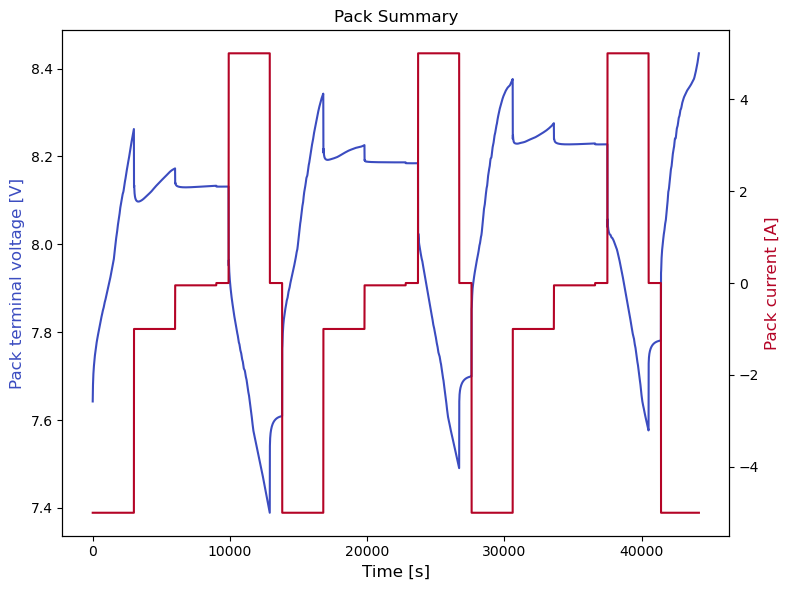

In [35]:
lp.plot_pack(output, color='white')
plt.show()

dict_keys(['Time [s]', 'Pack current [A]', 'Pack terminal voltage [V]', 'Cell current [A]', 'Cell internal resistance [Ohm]', 'Terminal voltage [V]', 'Surface open-circuit voltage [V]'])


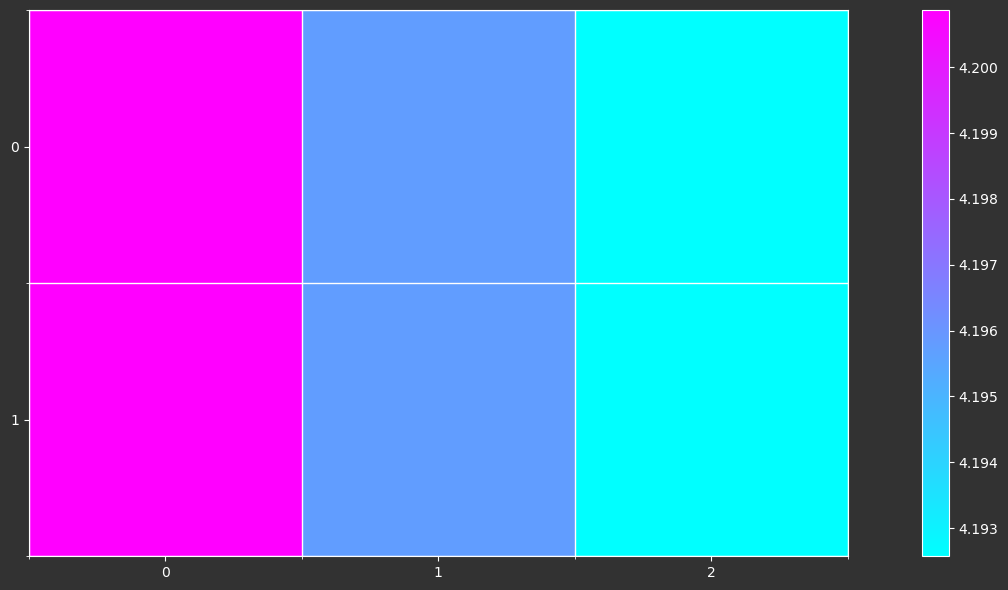

In [36]:
data = output['Terminal voltage [V]'][-1,:]
print(output.keys())
lp.plot_cell_data_image(netlist, data, tick_labels=True, figsize=(15, 6))
plt.show()

Stepping simulation:   0%|▏                                                         | 4882/1140001 [00:25<1:39:43, 189.71it/s]


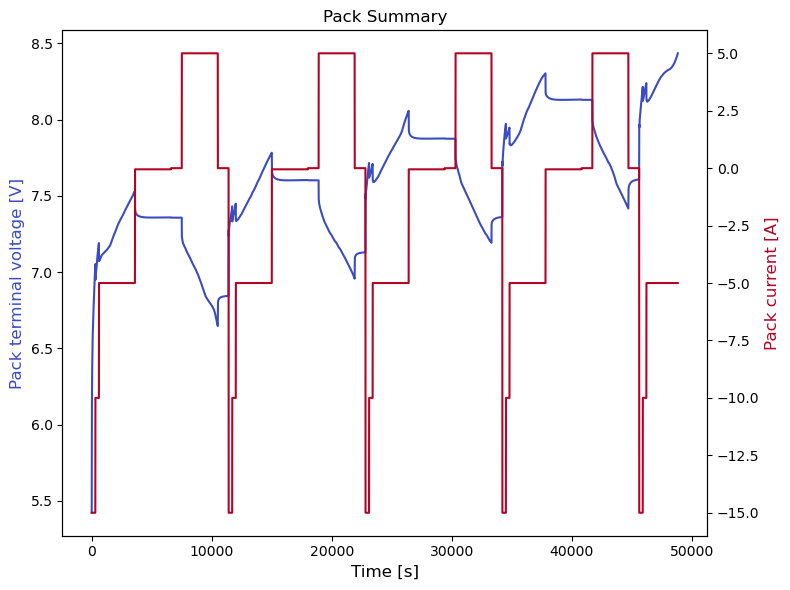

In [18]:
output = lp.solve(
    netlist=netlist,
    parameter_values=param,
    experiment=MCCCV,
    sim_func=SEI_degradation,
    initial_soc=0.5,
)

In [ ]:
lp.plot_pack(output, color='white')
plt.show()

In [ ]:
data_ = output_['Terminal voltage [V]'][-1,:]
print(output_.keys())
lp.plot_cell_data_image(netlist, data_, tick_labels=True, figsize=(15, 6))
plt.show()

### reference

In [32]:
I_mag = 5.0
OCV_init = 4.0
Ri_init = 5e-2
R_busbar = 1.5e-3
R_connection = 1e-2
Np = 3
Ns = 2
Nbatt = Np * Ns
netlist = lp.setup_circuit(
    Np=Np, Ns=Ns, 
    Rb=R_busbar, Rc=R_connection, Ri=Ri_init, 
    V=OCV_init, I=I_mag
)

In [33]:
netlist

,desc,node1,node2,value,node1_x,node1_y,node2_x,node2_y
0,Rbn0,1,2,0.00150,0,0,1,0
1,Rbn1,2,3,0.00150,1,0,2,0
2,Rc0,4,1,0.01000,0,1,0,0
3,V0,7,4,4.00000,0,2,0,1
4,Ri0,10,7,0.05000,0,3,0,2
5,Rc1,13,10,0.01000,0,4,0,3
6,V1,16,13,4.00000,0,5,0,4
7,Ri1,19,16,0.05000,0,6,0,5
8,Rc2,5,2,0.01000,1,1,1,0
9,V2,8,5,4.00000,1,2,1,1


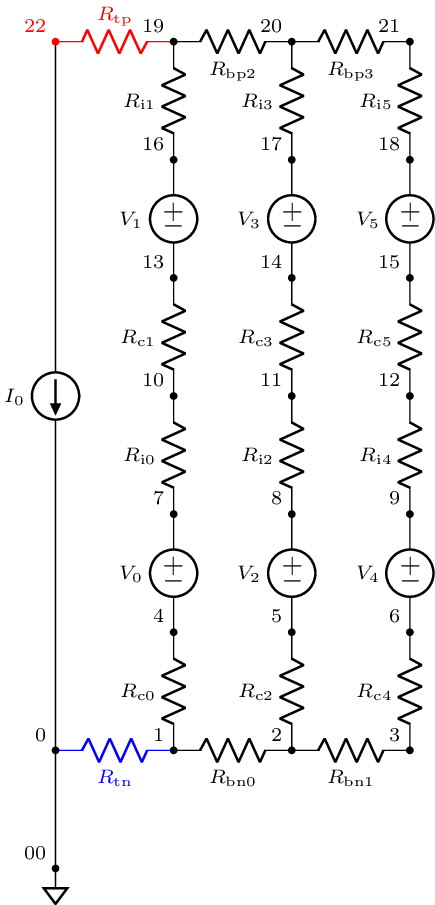

In [36]:
lp.draw_circuit(netlist, cpt_size=1.0, dpi=200, node_spacing=1.5, )

In [5]:
experiment = pybamm.Experiment(
    [
        "Charge at 5 A for 30 minutes",
        "Rest for 15 minutes",
        "Discharge at 5 A for 30 minutes",
        "Rest for 15 minutes",
    ],
    period="10 seconds",
)

parameter_values = pybamm.ParameterValues("Chen2020")
SPMe = pybamm.models.full_battery_models.lithium_ion.SPMe()

In [6]:
SPMe.variables.search("X-averaged")

Sum of x-averaged negative electrode electrolyte reaction source terms [A.m-3]
Sum of x-averaged negative electrode volumetric interfacial current densities [A.m-3]
Sum of x-averaged positive electrode electrolyte reaction source terms [A.m-3]
Sum of x-averaged positive electrode volumetric interfacial current densities [A.m-3]
X-averaged Ohmic heating [W.m-3]
X-averaged SEI film overpotential [V]
X-averaged battery concentration overpotential [V]
X-averaged battery electrolyte ohmic losses [V]
X-averaged battery negative reaction overpotential [V]
X-averaged battery negative solid phase ohmic losses [V]
X-averaged battery positive reaction overpotential [V]
X-averaged battery positive solid phase ohmic losses [V]
X-averaged battery reaction overpotential [V]
X-averaged battery solid phase ohmic losses [V]
X-averaged cell temperature [C]
X-averaged cell temperature [K]
X-averaged concentration overpotential [V]
X-averaged electrolyte concentration [Molar]
X-averaged electrolyte concent

In [7]:
output_variables = [
    "X-averaged negative particle surface concentration [mol.m-3]",
    "X-averaged positive particle surface concentration [mol.m-3]",
]

In [8]:
output = lp.solve(
    netlist=netlist,
    parameter_values=parameter_values,
    experiment=experiment,
    output_variables=output_variables,
    initial_soc=0.5
)

Stepping simulation: 100%|███████████████████████████████████████████████████████████| 541/541 [00:02<00:00, 205.03it/s]


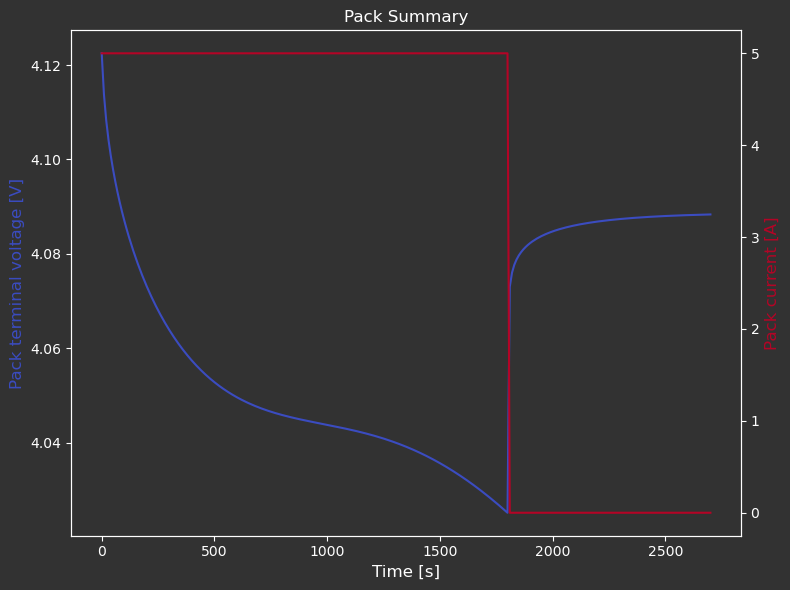

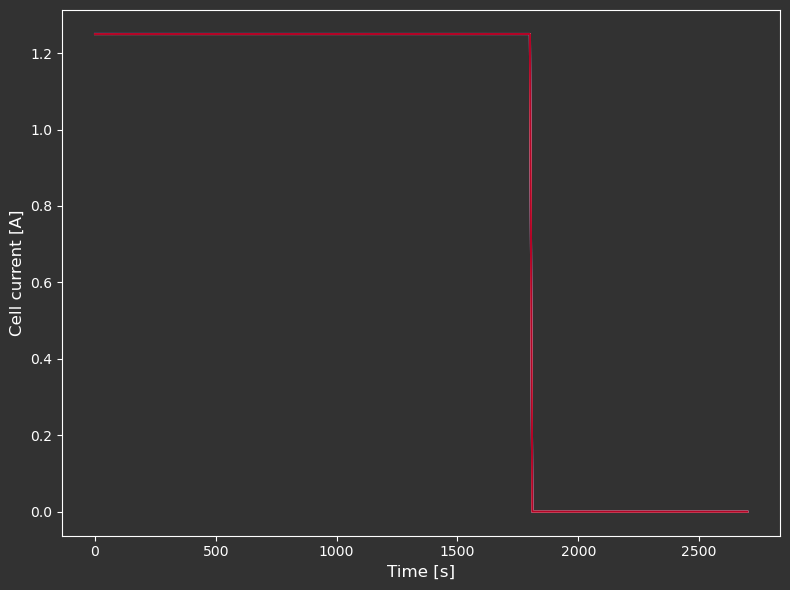

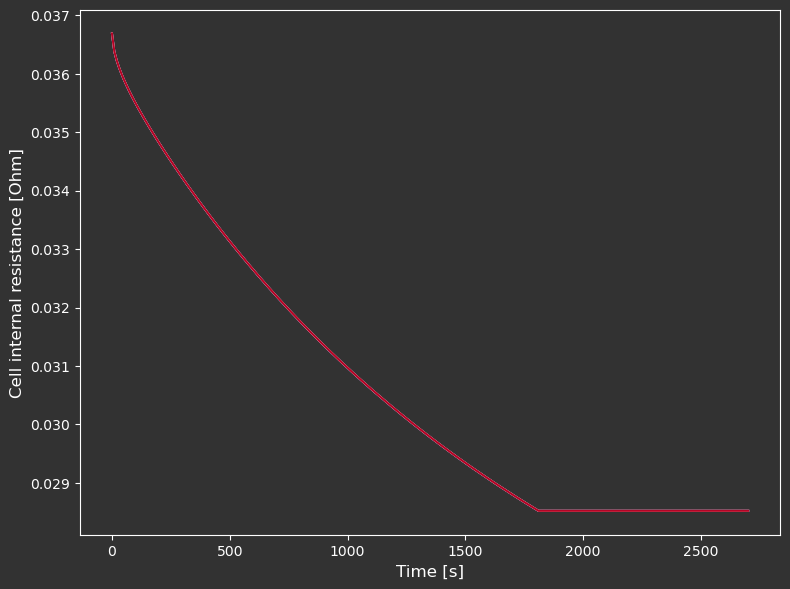

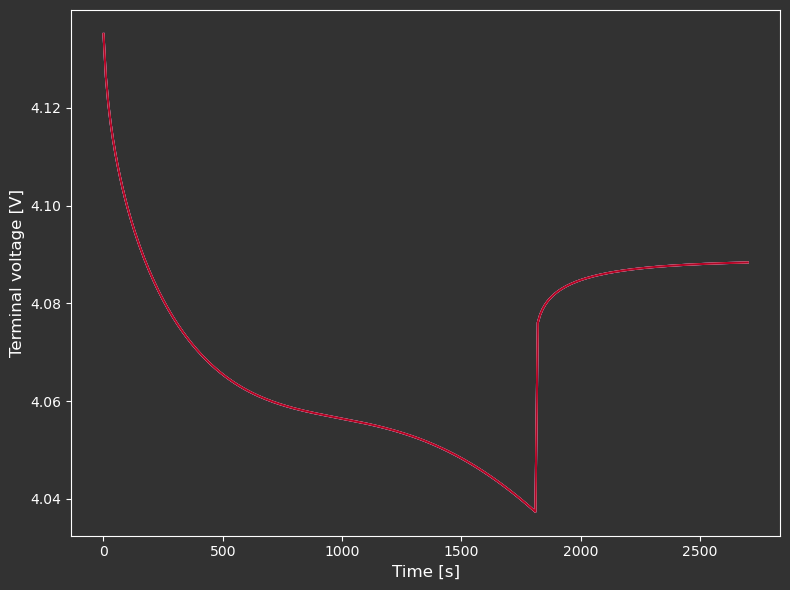

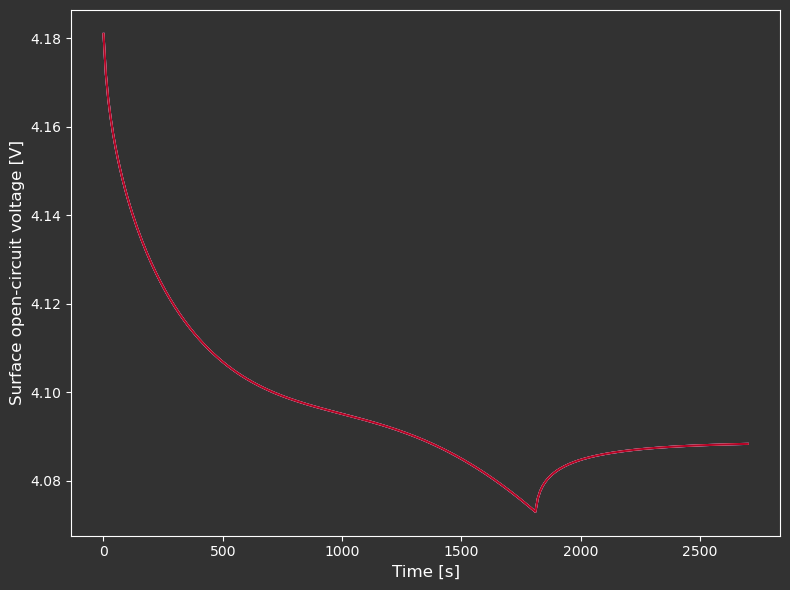

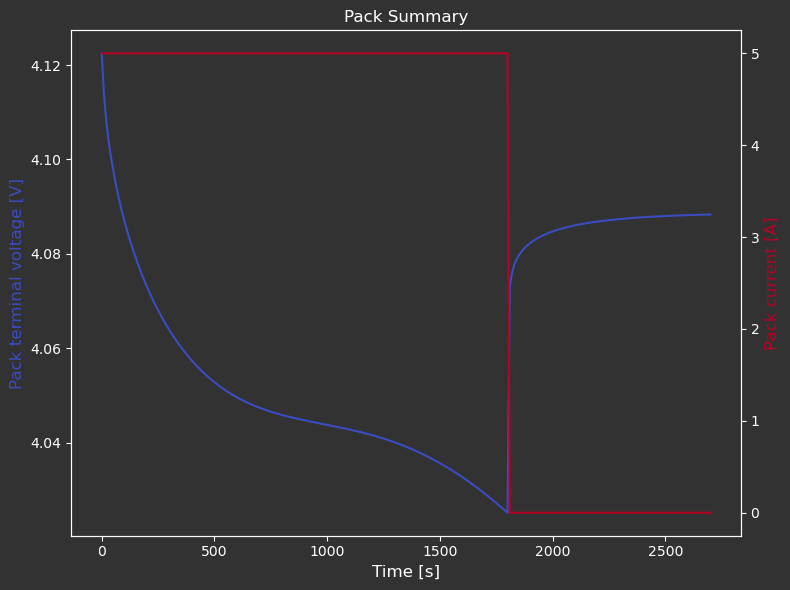

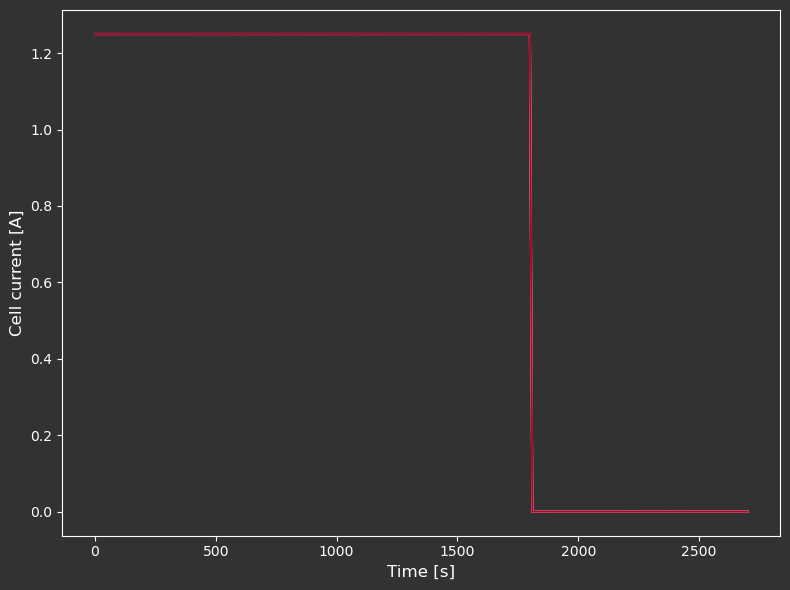

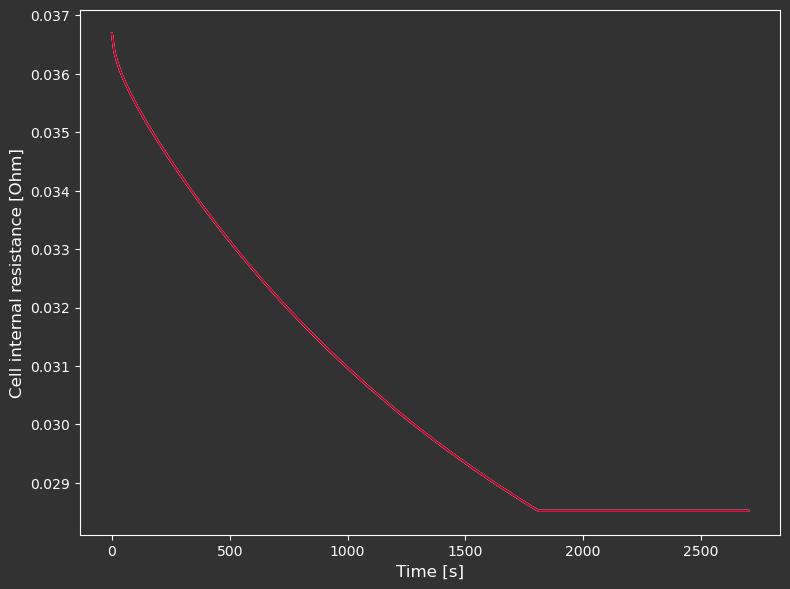

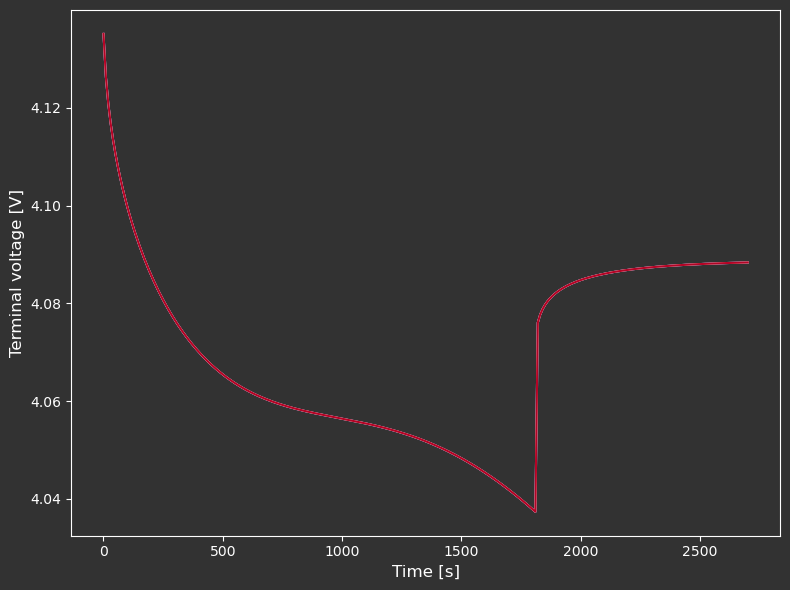

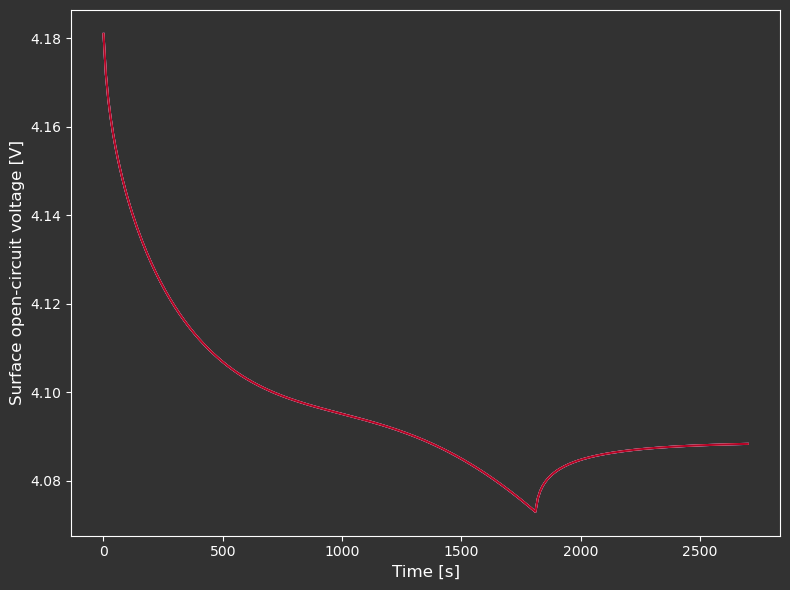

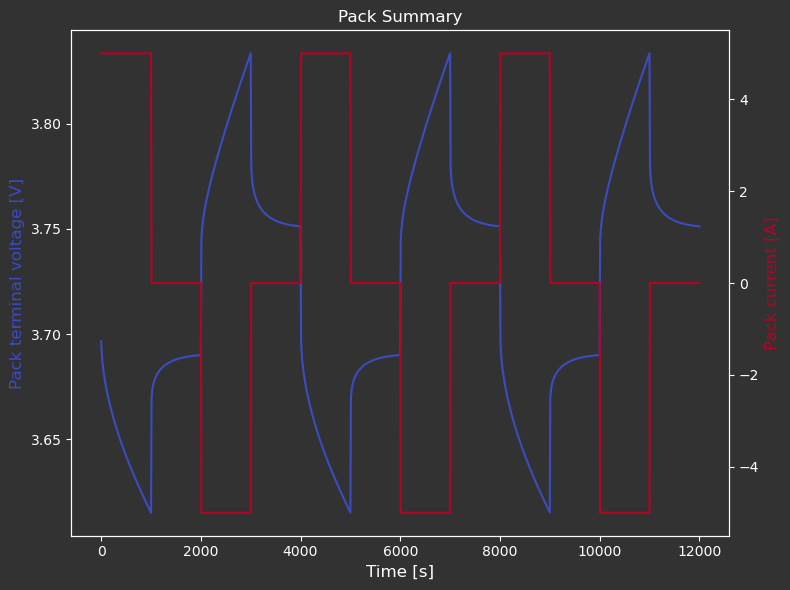

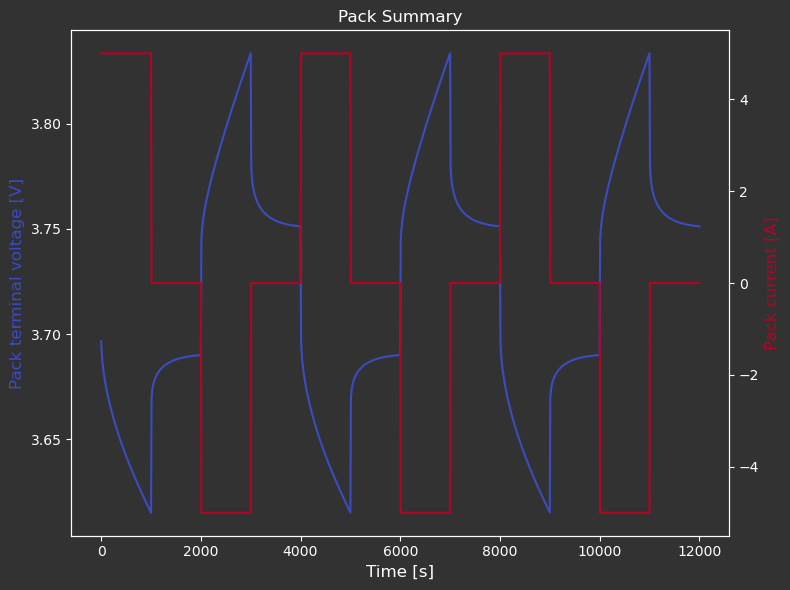

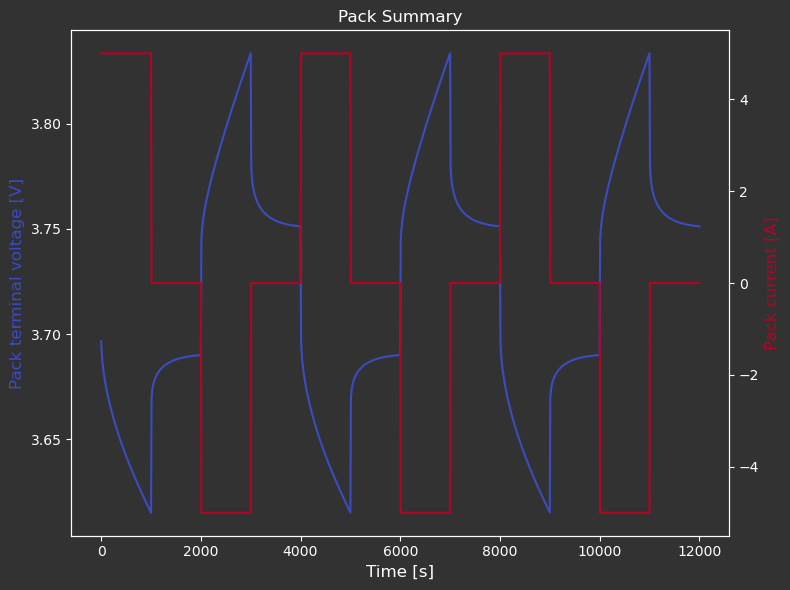

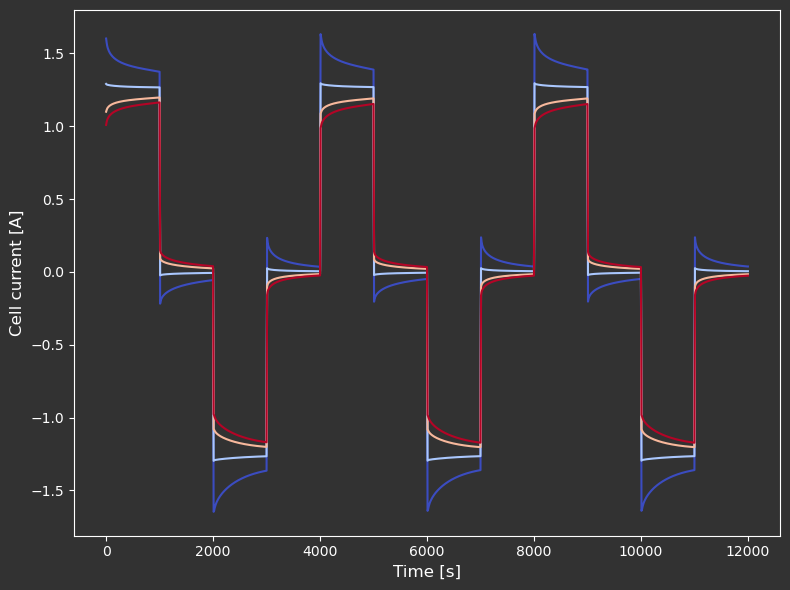

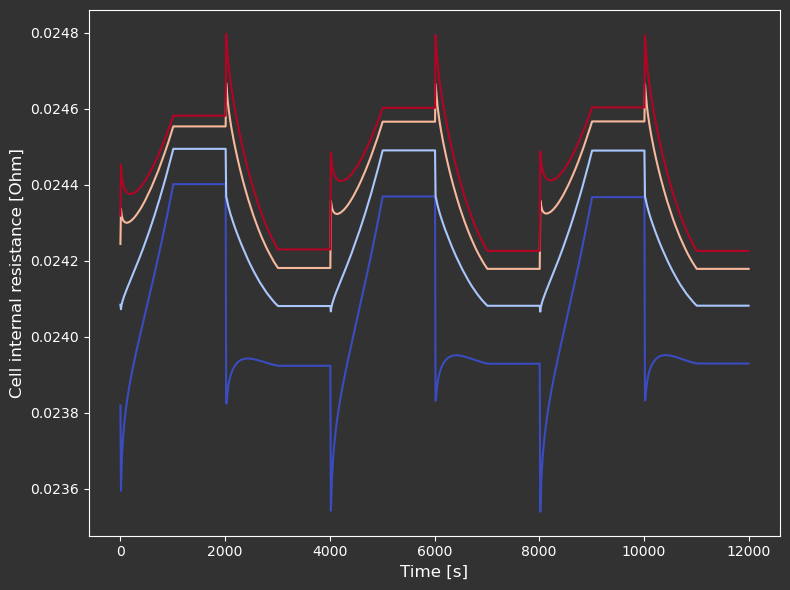

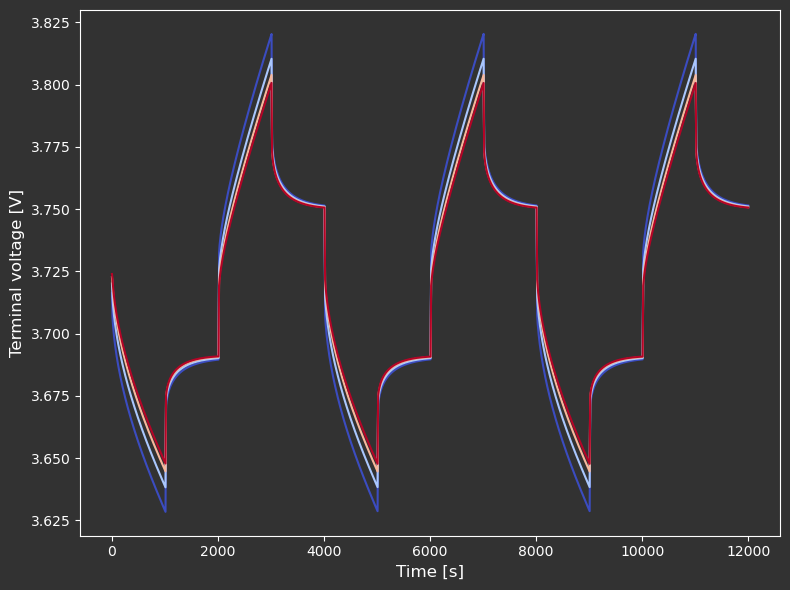

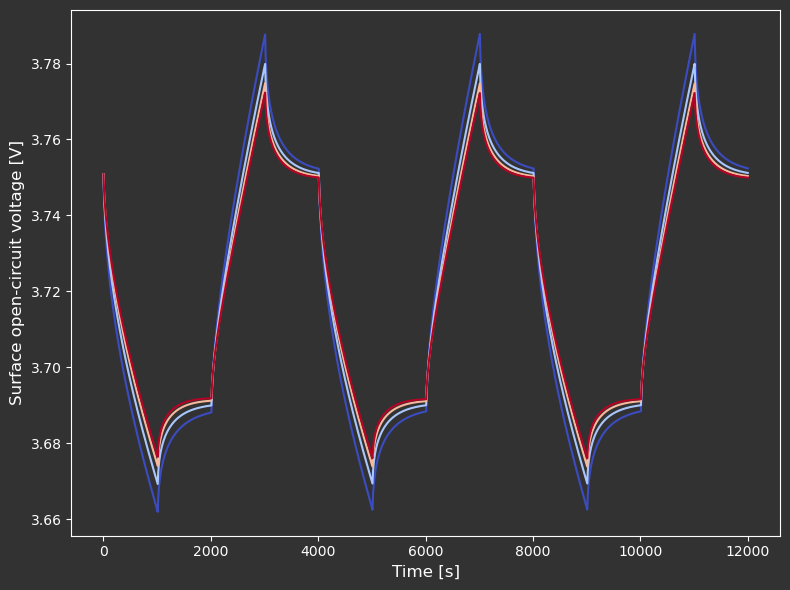

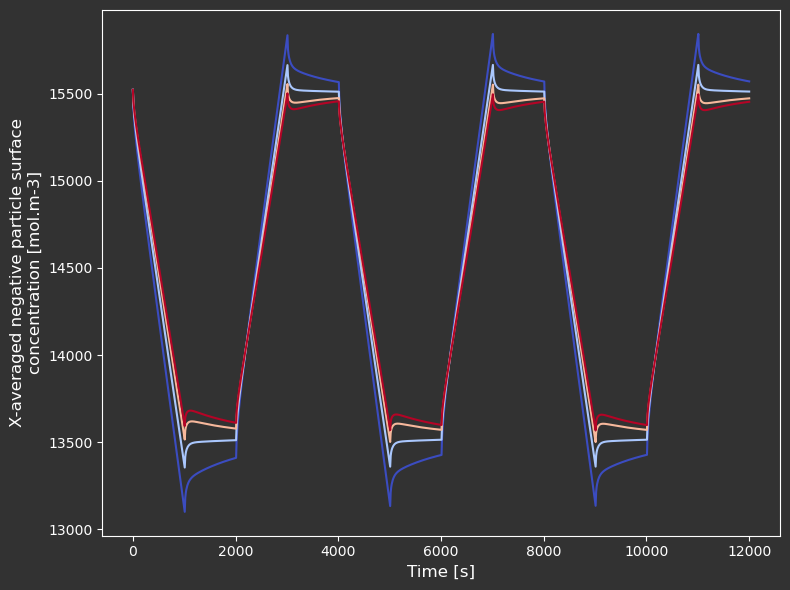

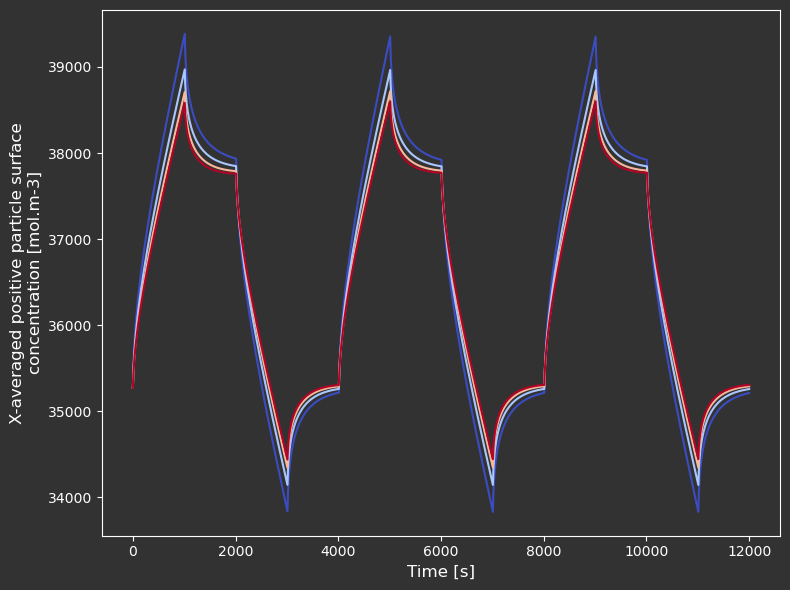

In [25]:
lp.plot_output(output)
plt.show()

In [10]:
I_mag = 5.0
OCV_init = 4.0  # used for intial guess
Ri_init = 5e-2  # used for intial guess
R_busbar = 1.5e-6  # very small to simulate evenly distributed currents
R_connection = 1e-2
Np = 4
Ns = 1
Nbatt = Np * Ns
netlist = lp.setup_circuit(
    Np=Np, Ns=Ns, Rb=R_busbar, Rc=R_connection, Ri=Ri_init, V=OCV_init, I=I_mag
)

In [11]:
experiment = pybamm.Experiment(
    ["Discharge at 5 A for 30 minutes", "Rest for 15 minutes"],
    period="10 seconds",
)

parameter_values = pybamm.ParameterValues("Chen2020")
parameter_values.search("porosity")

Negative electrode porosity	0.25
Positive electrode porosity	0.335
Separator porosity	0.47


In [12]:
parameter_values.update({"Positive electrode porosity": "[input]"})
inputs = {"Positive electrode porosity": np.ones(4) * 0.335}

In [13]:
output = lp.solve(
    netlist=netlist,
    parameter_values=parameter_values,
    experiment=experiment,
    inputs=inputs,
)

Stepping simulation: 100%|███████████████████████████████████████████████████████████| 271/271 [00:01<00:00, 208.35it/s]


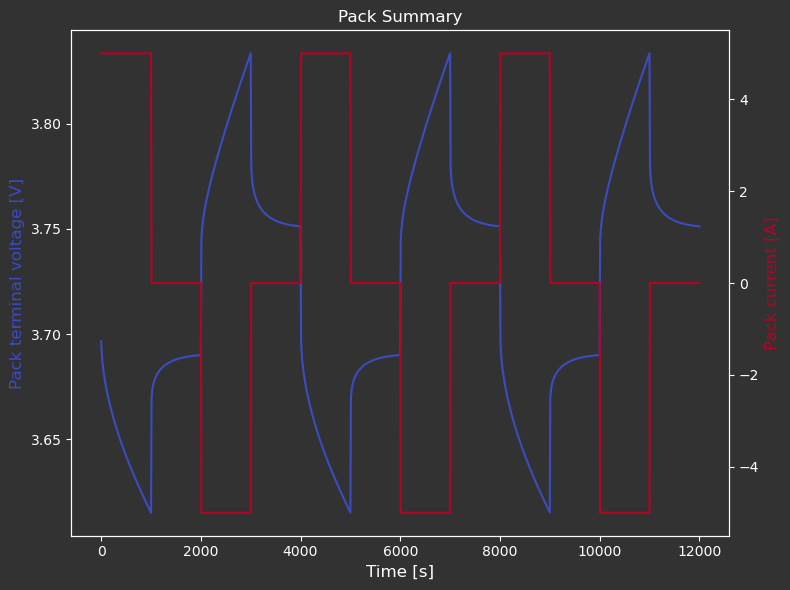

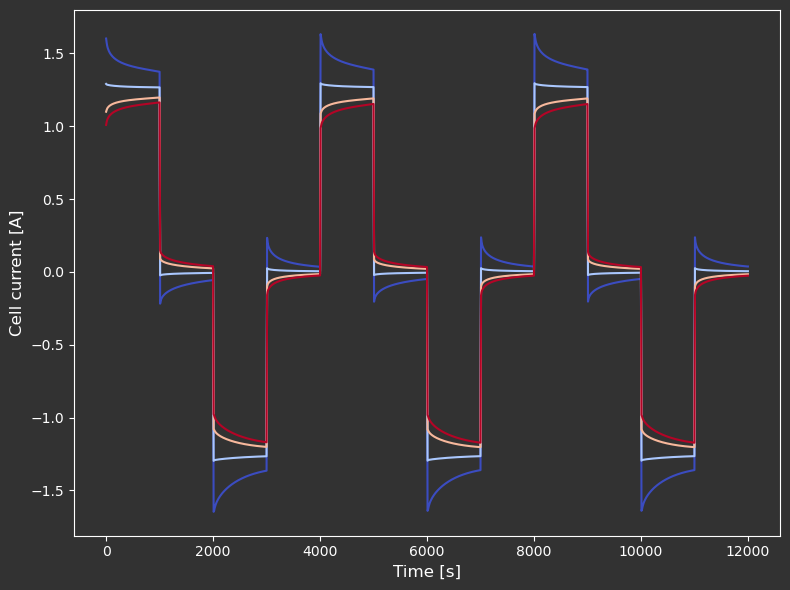

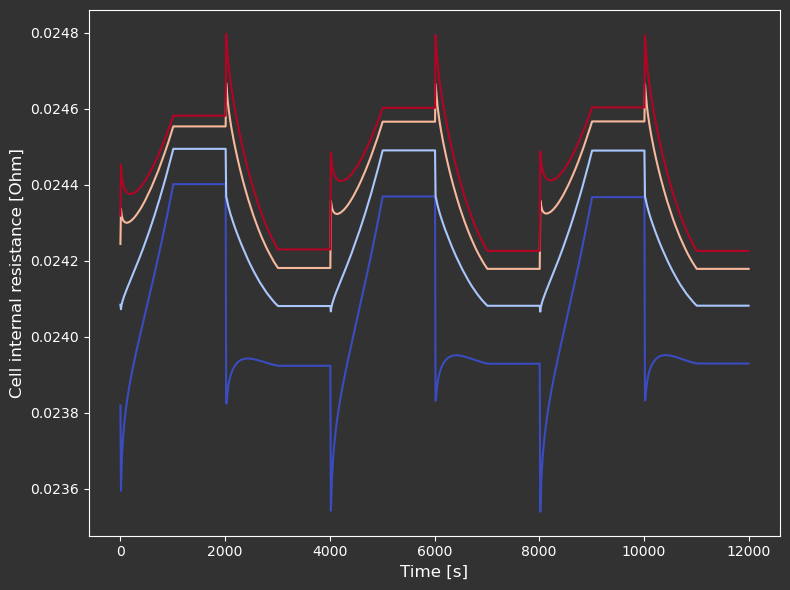

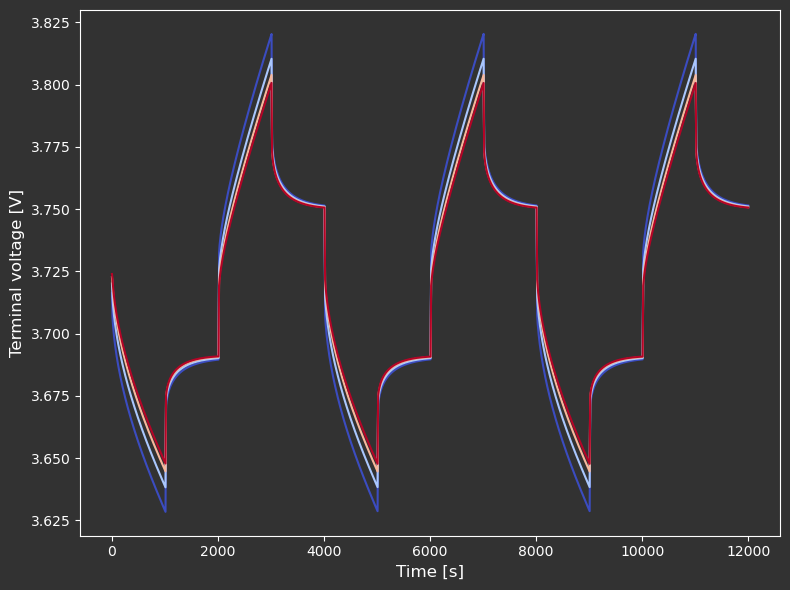

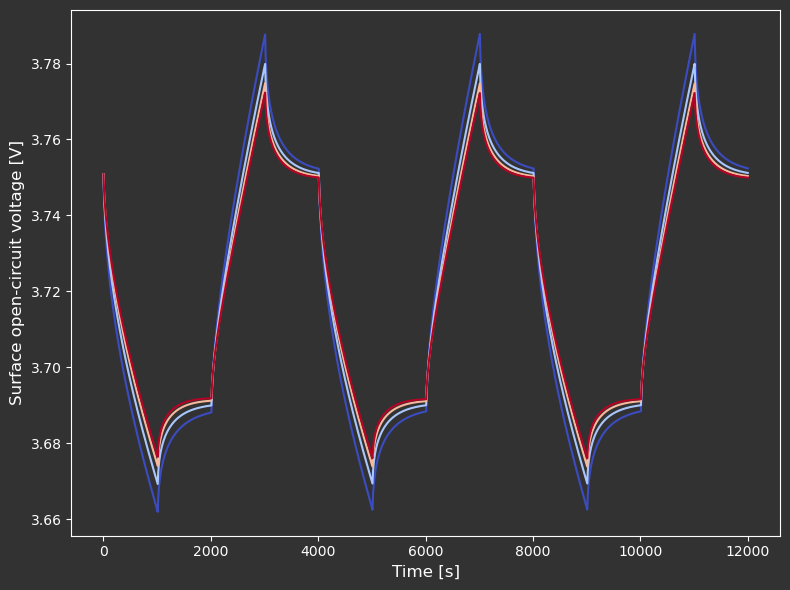

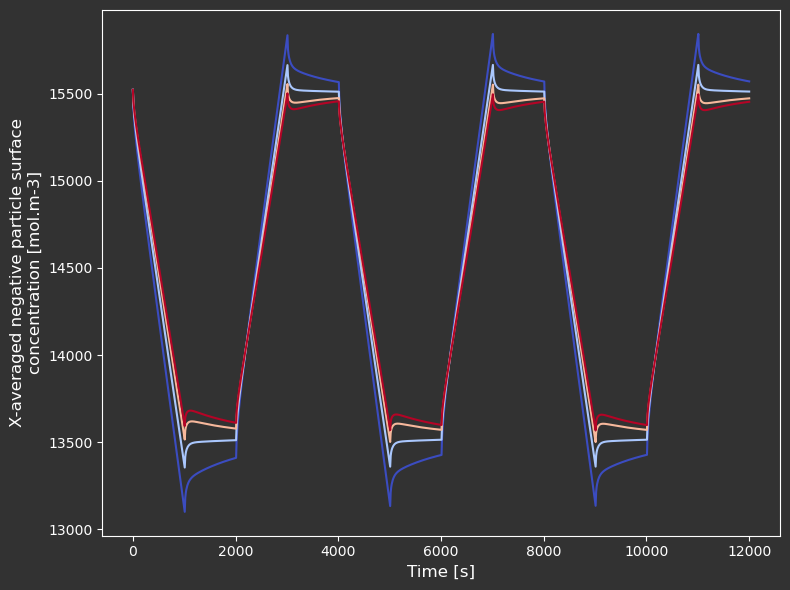

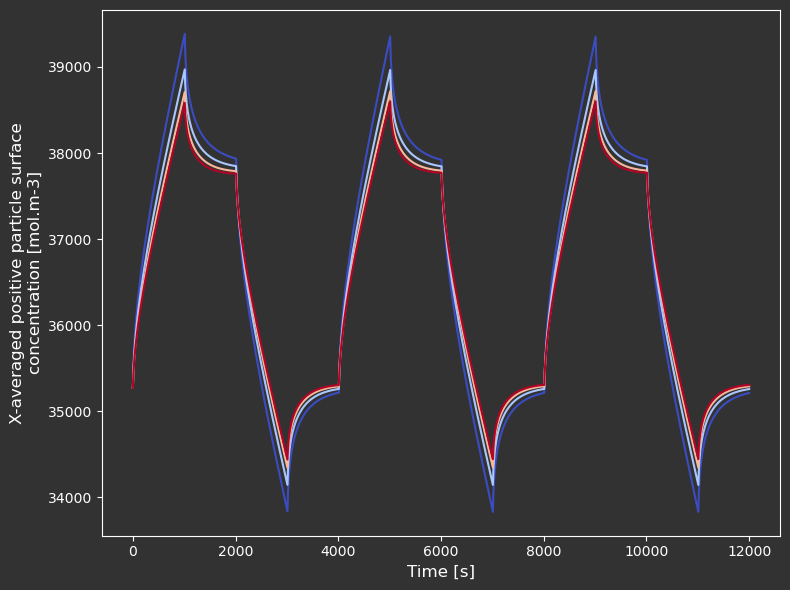

In [26]:
lp.plot_output(output)
plt.show()

In [15]:
inputs = {"Positive electrode porosity": np.linspace(0.5, 1.5, 4) * 0.335}
output = lp.solve(
    netlist=netlist,
    parameter_values=parameter_values,
    experiment=experiment,
    inputs=inputs,
)

Stepping simulation: 100%|███████████████████████████████████████████████████████████| 271/271 [00:01<00:00, 208.38it/s]


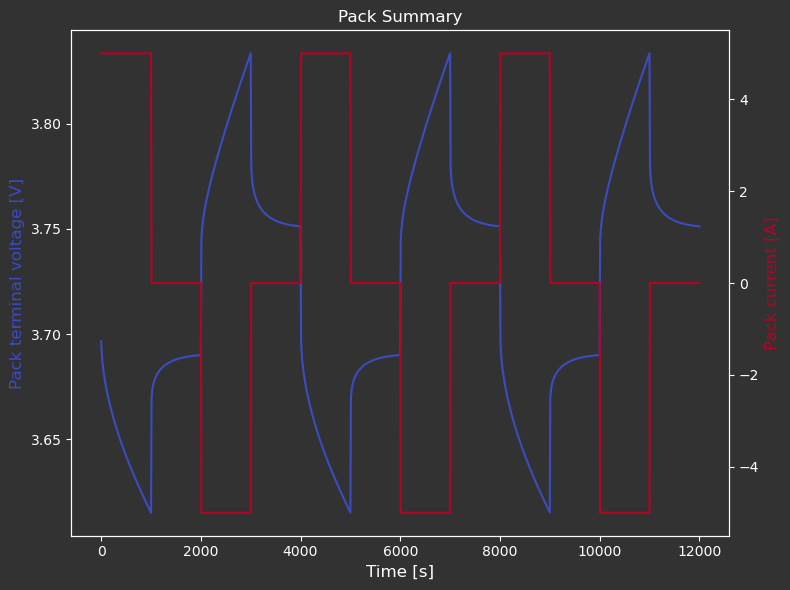

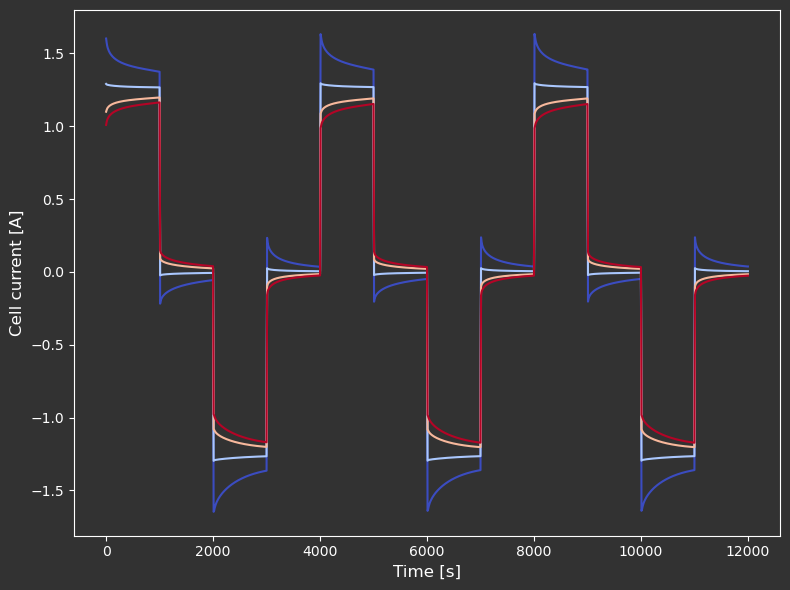

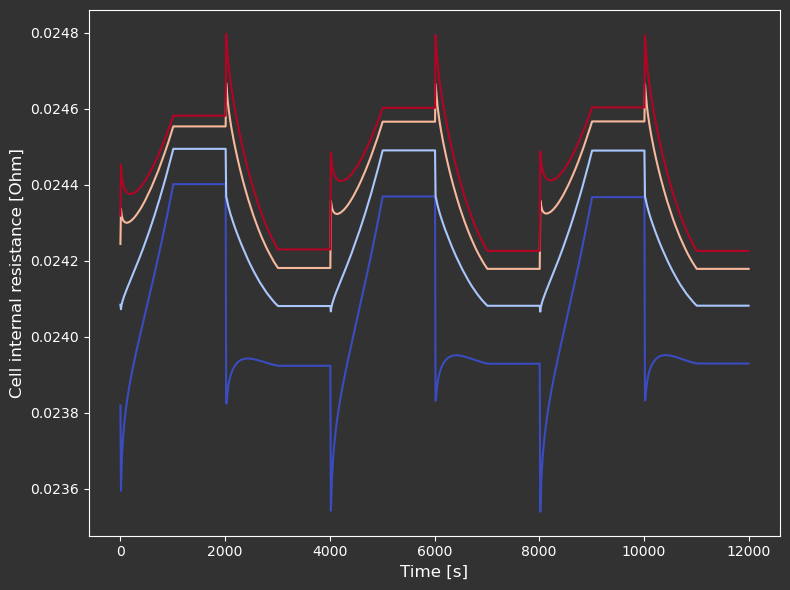

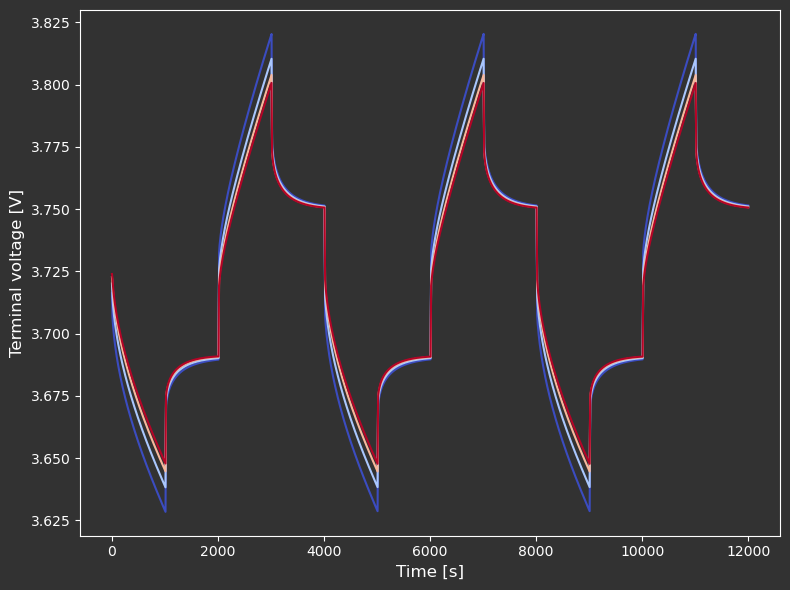

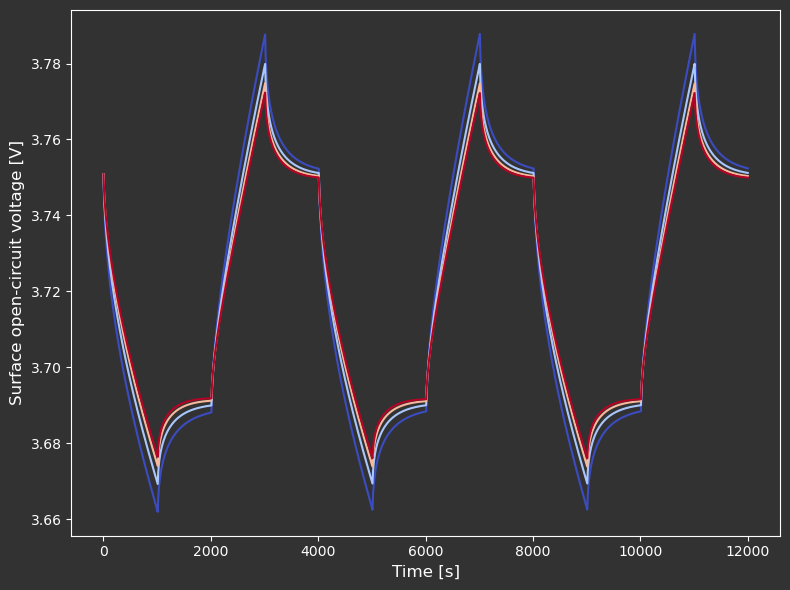

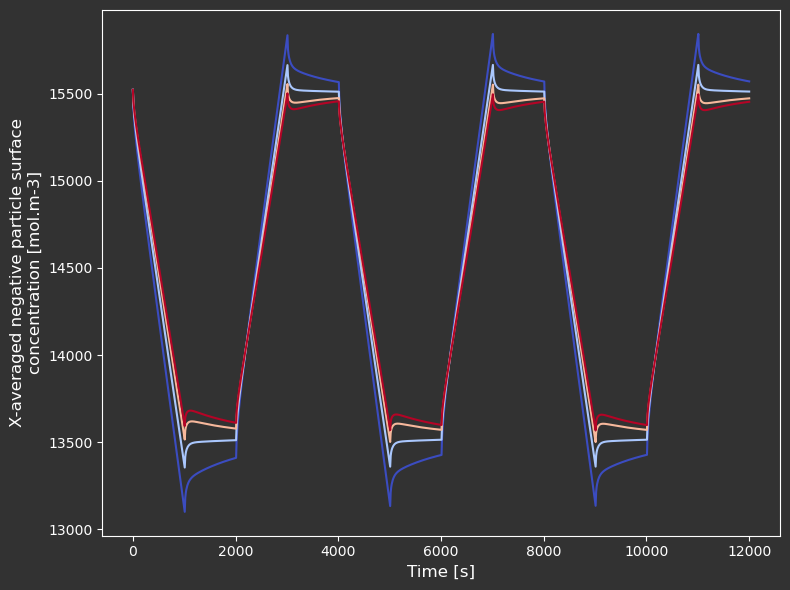

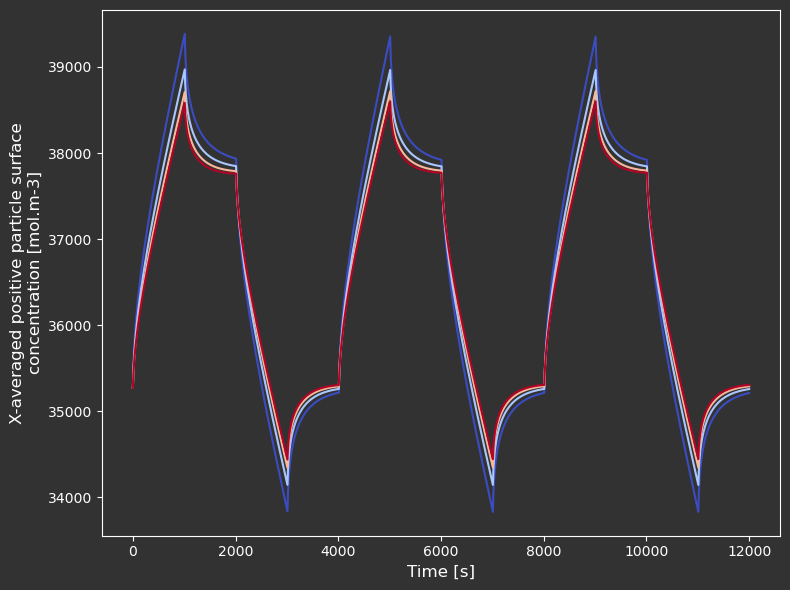

In [27]:
lp.plot_output(output)
plt.show()

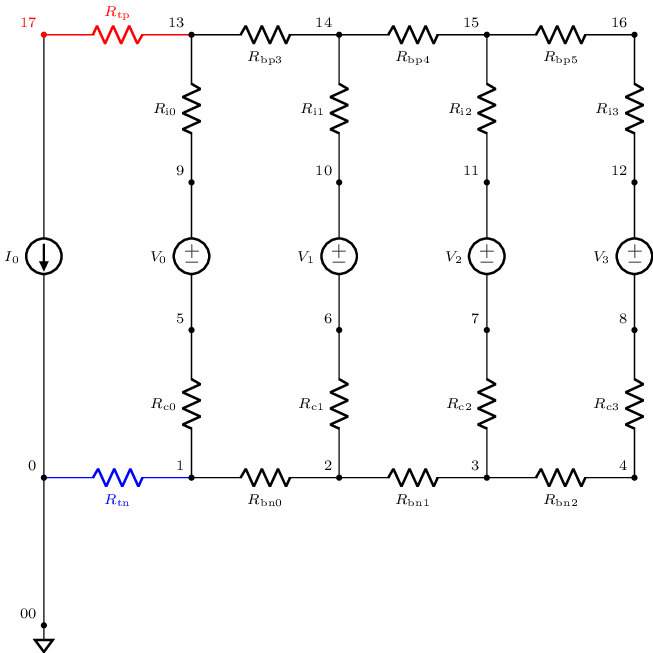

In [17]:
# Generate the netlist
netlist = lp.setup_circuit(Np=4, Ns=1, Rb=1.5e-3, Rc=1e-2, Ri=5e-2, V=4.0, I=5.0)
lp.draw_circuit(netlist, cpt_size=1.0, dpi=200, node_spacing=2.5, scale=0.75)

In [18]:
output_variables = [
    "X-averaged negative particle surface concentration [mol.m-3]",
    "X-averaged positive particle surface concentration [mol.m-3]",
]

# PyBaMM parameters
parameter_values = pybamm.ParameterValues("Chen2020")

In [19]:
# Cycling experiment
experiment = pybamm.Experiment(
    [
        (
            "Discharge at 5 A for 1000 s or until 3.3 V",
            "Rest for 1000 s",
            "Charge at 5 A for 1000 s or until 4.1 V",
            "Rest for 1000 s",
        )
    ]
    * 3,
    period="10 s",
)

In [20]:
experiment.operating_conditions_steps

[_Step(current, 5.0, duration=1000 s, termination=3.3 V, description=Discharge at 5 A for 1000 s or until 3.3 V),
 _Step(current, 0, duration=1000 s, description=Rest for 1000 s),
 _Step(current, -5.0, duration=1000 s, termination=4.1 V, description=Charge at 5 A for 1000 s or until 4.1 V),
 _Step(current, 0, duration=1000 s, description=Rest for 1000 s),
 _Step(current, 5.0, duration=1000 s, termination=3.3 V, description=Discharge at 5 A for 1000 s or until 3.3 V),
 _Step(current, 0, duration=1000 s, description=Rest for 1000 s),
 _Step(current, -5.0, duration=1000 s, termination=4.1 V, description=Charge at 5 A for 1000 s or until 4.1 V),
 _Step(current, 0, duration=1000 s, description=Rest for 1000 s),
 _Step(current, 5.0, duration=1000 s, termination=3.3 V, description=Discharge at 5 A for 1000 s or until 3.3 V),
 _Step(current, 0, duration=1000 s, description=Rest for 1000 s),
 _Step(current, -5.0, duration=1000 s, termination=4.1 V, description=Charge at 5 A for 1000 s or until 

In [21]:
# Solve pack
output = lp.solve(
    netlist=netlist,
    parameter_values=parameter_values,
    experiment=experiment,
    output_variables=output_variables,
    initial_soc=0.5
)

Stepping simulation: 100%|█████████████████████████████████████████████████████████| 1201/1201 [00:05<00:00, 207.91it/s]


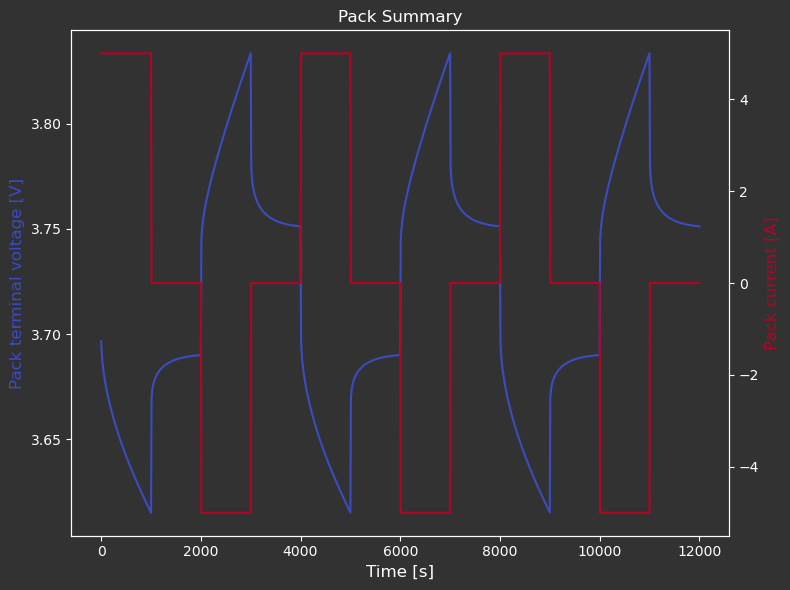

In [28]:
lp.plot_pack(output)
plt.show()